In [ ]:
#!pip install -U imbalanced-learn
#!pip install -U scikit-learn

In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=8df5fa566a68a976c2b441428281f2dee24766f6b28bef8fc09accc5c5867056
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import time
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, \
                                      NaiveBayes, RandomForestClassifier, GBTClassifier, \
                                      MultilayerPerceptronClassifier, LinearSVC, \
                                      OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
from pyspark.sql import SparkSession
# Initialize Spark session
spark = SparkSession.builder.appName("IntrusionDetection").getOrCreate()

In [ ]:
start = time.time()

In [ ]:
features = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
            "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
            "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
            "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
            "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
            "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
            "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
            "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
            "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

In [ ]:
dataset = spark.read.csv("/content/corrected", inferSchema=True, header=False)

In [ ]:
dataset = dataset.toDF(*features)

In [ ]:
from pyspark.sql.functions import regexp_replace
dataset = dataset.withColumn("label", regexp_replace("label", "\.", ""))

In [ ]:
print("Dataset sizes: {row} samples, {cols} features".format(row=dataset.count(), cols=len(dataset.columns)))

Dataset sizes: 311029 samples, 42 features


In [ ]:
def find_categorical_columns(df):
    categorical_columns = [col for (col, data_type) in df.dtypes if data_type == "string"]
    return categorical_columns

In [ ]:
# Identify categorical columns in the DataFrame
categorical_columns = find_categorical_columns(dataset)

# Print the result
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['protocol_type', 'service', 'flag', 'label']


In [ ]:
# Check the schema and data
dataset.printSchema()
dataset.show()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [ ]:
categorical_features = ["protocol_type", "service", "flag"]
indexers = [StringIndexer(inputCol=column, outputCol=column + "_num") for column in categorical_features]

In [ ]:
indexers

[StringIndexer_4a51a174a488,
 StringIndexer_4e5e4c902054,
 StringIndexer_562c725da8f6]

In [ ]:
indexers.append(StringIndexer(inputCol="label", outputCol="label_num"))
pipeline = Pipeline(stages=indexers)
dataset = pipeline.fit(dataset).transform(dataset)

In [ ]:
dataset.show()

+--------+-------------+--------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------------+-----------------+-----------+--------+---------+
|duration|protocol_type| service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_ra

In [ ]:
exclude_list = categorical_features + ["label", "label_num"]
# print("Exclude list:")
print(exclude_list)

['protocol_type', 'service', 'flag', 'label', 'label_num']


In [ ]:
numerical_cols = [col for col in dataset.columns if col not in exclude_list]
print(numerical_cols)

['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_num', 'service_num', 'flag_num']


In [ ]:
df_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
dataset = df_assembler.transform(dataset)
dataset.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

In [ ]:
from pyspark.sql.functions import col
# List of string columns to drop
string_columns_to_drop = ['protocol_type', 'service', 'flag', 'label']

# Drop the string columns
dataset = dataset.select([col(column) for column in dataset.columns if column not in string_columns_to_drop])

In [ ]:
dataset.show()

+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------------+-----------+--------+---------+--------------------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate

In [ ]:
train_set, test_set = dataset.randomSplit([0.90, 0.10], seed=2019)
print("Training set Count: " + str(train_set.count()))
print("Test set Count: " + str(test_set.count()))

Training set Count: 279907
Test set Count: 31122


In [ ]:
test_set.show()

+--------+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-----------------+-----------+--------+---------+--------------------+
|duration|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
'''import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline'''

'import pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\n%matplotlib inline'

In [ ]:
# Counting occurrences of each unique value in the output column
label_counts = test_set.groupBy("label_num").count().orderBy("label_num")
label_counts.show()

+---------+-----+
|label_num|count|
+---------+-----+
|      0.0|16539|
|      1.0| 6019|
|      2.0| 5782|
|      3.0|  758|
|      4.0|  491|
|      5.0|  394|
|      6.0|  247|
|      7.0|  153|
|      8.0|  158|
|      9.0|  100|
|     10.0|  117|
|     11.0|   89|
|     12.0|   90|
|     13.0|   69|
|     14.0|   41|
|     15.0|   23|
|     16.0|   14|
|     17.0|   10|
|     18.0|    9|
|     19.0|    5|
+---------+-----+
only showing top 20 rows



In [ ]:
# Print all values
print("Label Counts:")
label_counts.show(label_counts.count(), False)

Label Counts:
+---------+-----+
|label_num|count|
+---------+-----+
|0.0      |16539|
|1.0      |6019 |
|2.0      |5782 |
|3.0      |758  |
|4.0      |491  |
|5.0      |394  |
|6.0      |247  |
|7.0      |153  |
|8.0      |158  |
|9.0      |100  |
|10.0     |117  |
|11.0     |89   |
|12.0     |90   |
|13.0     |69   |
|14.0     |41   |
|15.0     |23   |
|16.0     |14   |
|17.0     |10   |
|18.0     |9    |
|19.0     |5    |
|20.0     |1    |
|21.0     |2    |
|22.0     |3    |
|23.0     |1    |
|24.0     |2    |
|25.0     |3    |
|26.0     |1    |
|30.0     |1    |
+---------+-----+



In [ ]:
# Set the threshold for minimum occurrences
threshold = 90

# Filter the label counts DataFrame to keep only the rows with counts greater than or equal to the threshold
filtered_label_counts = label_counts.filter(label_counts["count"] >= threshold)

# Extract the label numbers that meet the threshold
selected_labels = filtered_label_counts.select("label_num").rdd.flatMap(lambda x: x).collect()

# Filter the training set to keep only the rows with labels that meet the threshold
filtered_train_set = test_set.filter(test_set["label_num"].isin(selected_labels))

# Display the new label counts after filtering
new_label_counts = filtered_train_set.groupBy("label_num").count().orderBy("count", ascending=False)
print("New Label Counts in the Training Set:")
new_label_counts.show(new_label_counts.count(), False)

# Split features and labels in the filtered training set
filtered_train_features = filtered_train_set.select("features")
filtered_train_labels = filtered_train_set.select("label_num")

New Label Counts in the Training Set:
+---------+-----+
|label_num|count|
+---------+-----+
|0.0      |16539|
|1.0      |6019 |
|2.0      |5782 |
|3.0      |758  |
|4.0      |491  |
|5.0      |394  |
|6.0      |247  |
|8.0      |158  |
|7.0      |153  |
|10.0     |117  |
|9.0      |100  |
|12.0     |90   |
+---------+-----+



In [ ]:
filtered_train_features.show()

+--------------------+
|            features|
+--------------------+
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,21,22,...|
|(41,[19,20,21,22,...|
|(41,[19,20,21,22,...|
|(41,[19,20,21,22,...|
|(41,[19,20,21,22,...|
|(41,[19,20,21,22,...|
|(41,[19,20,23,24,...|
|(41,[19,20,23,24,...|
|(41,[19,20,21,22,...|
|(41,[19,20,21,22,...|
+--------------------+
only showing top 20 rows



In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
train_pd_df = test_set.toPandas()

# Separate features and labels
X_train = filtered_train_features.toPandas()
X_train

,features
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
30843,"(8084.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
30844,"(8088.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
30845,"(8092.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
30846,"(8224.0, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."


In [ ]:
y_train = filtered_train_labels.toPandas()

In [ ]:
y_train

,label_num
0,10.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
30843,12.0
30844,12.0
30845,12.0
30846,12.0


In [ ]:
# Separate features and labels
X_train = X_train["features"].tolist()
y_train = y_train["label_num"].tolist()

In [ ]:
# Instantiate ADASYN with optional parameters
adasyn = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5)
# Apply ADASYN to the training data
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

In [ ]:
len(X_resampled)

47297

In [ ]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col
import pandas as pd
# Combine resampled features and labels into a new DataFrame
resampled_features = [DenseVector(x) for x in X_resampled]
train_set_resampled = spark.createDataFrame(pd.DataFrame(data={"features_dense": resampled_features, "label_num": y_resampled}))
train_set_resampled = train_set_resampled.withColumn("label_num", col("label_num").cast("integer"))

In [ ]:
train_set_resampled.printSchema()

root
 |-- features_dense: vector (nullable = true)
 |-- label_num: integer (nullable = true)



In [ ]:
# Counting occurrences of each unique value in the output column
label_counts = train_set_resampled.groupBy("label_num").count().orderBy("label_num")
label_counts.show()

+---------+-----+
|label_num|count|
+---------+-----+
|        0|16539|
|        1| 6019|
|        2| 5782|
|        3|  758|
|        4|  491|
|        5|  394|
|        6|  247|
|        7|  153|
|        8|  158|
|        9|  100|
|       10|  117|
|       12|16539|
+---------+-----+



In [ ]:
'''# Display the count of occurrences after applying SMOTE
resampled_label_counts = resampled_df.groupBy("label_num").count().orderBy("count", ascending=False)
resampled_label_counts.show()'''

'# Display the count of occurrences after applying SMOTE\nresampled_label_counts = resampled_df.groupBy("label_num").count().orderBy("count", ascending=False)\nresampled_label_counts.show()'

In [ ]:
train_set1, test_set1 = train_set_resampled.randomSplit([0.90, 0.10], seed=2019)
#print("Training set Count: " + str(train_set1.count()))
#print("Test set Count: " + str(test_set1.count()))

In [ ]:
test_set1.show()

+--------------------+---------+
|      features_dense|label_num|
+--------------------+---------+
|[0.0,0.0,0.0,0.0,...|       10|
|[0.0,0.0,0.0,0.0,...|       10|
|[0.0,0.0,0.0,0.0,...|        1|
|[0.0,0.0,0.0,0.0,...|       10|
|[0.0,0.0,0.0,0.0,...|       10|
|[0.0,0.0,0.0,0.0,...|       10|
|[0.0,0.0,0.0,0.0,...|       10|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|       10|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
|[0.0,0.0,0.0,0.0,...|        2|
+--------------------+---------+
only showing top 20 rows



In [ ]:
train_set1.printSchema()

root
 |-- features_dense: vector (nullable = true)
 |-- label_num: integer (nullable = true)



In [ ]:
# Logistic Regression model
lr1 = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0.8, featuresCol="features_dense",
                        labelCol="label_num", family="multinomial")

# Decision Tree model
dt1 = DecisionTreeClassifier(labelCol="label_num", featuresCol="features_dense",  maxBins=70)

# Random Forest model
rf1 = RandomForestClassifier(labelCol="label_num", featuresCol="features_dense", numTrees=20, maxBins=70)

# Naive Bayes Multinomial
nb1 = NaiveBayes(labelCol="label_num", featuresCol="features_dense", smoothing=1.0, modelType="multinomial")

# Linear SVM model
lsvc1 = LinearSVC(labelCol="label_num", featuresCol="features_dense", maxIter=10)

# OneVsRest wrapper
ovr1 = OneVsRest(classifier=lsvc1, labelCol="label_num", featuresCol="features_dense")

# Multi Layer Perceptron
multilayer_perceptron1 = MultilayerPerceptronClassifier(labelCol="label_num", featuresCol="features_dense",
                                                       layers=[len(numerical_cols), 10, 5, 38], blockSize=128, seed=1234)

In [ ]:
classifiers = {"Logistic Regression": lr1, "Decision Tree": dt1,
               "Random Forest": rf1, "Naive Bayes Multinomial": nb1,
               "Multilayer Perceptron": multilayer_perceptron1}

metrics = ["accuracy", "weightedPrecision", "weightedRecall", "f1"]

In [ ]:
for c in classifiers:
    print(c)
    # fit the model using the correct classifier
    model = classifiers[c].fit(train_set1)

    # make predictions
    predictions = model.transform(test_set1)
    predictions.cache()

    # evaluate performance
    evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction")

    for m in metrics:
        evaluator.setMetricName(m)
        metric_value = evaluator.evaluate(predictions)
        print("{name} = {value:.2f}".format(name=m, value=metric_value))

    print("{:-<30}".format(""))

Logistic Regression
accuracy = 0.78
weightedPrecision = 0.65
weightedRecall = 0.78
f1 = 0.70
------------------------------
Decision Tree
accuracy = 0.96
weightedPrecision = 0.94
weightedRecall = 0.96
f1 = 0.95
------------------------------
Random Forest
accuracy = 0.96
weightedPrecision = 0.94
weightedRecall = 0.96
f1 = 0.95
------------------------------
Naive Bayes Multinomial
accuracy = 0.58
weightedPrecision = 0.62
weightedRecall = 0.58
f1 = 0.59
------------------------------
Multilayer Perceptron
accuracy = 0.95
weightedPrecision = 0.92
weightedRecall = 0.95
f1 = 0.93
------------------------------


In [ ]:
# Train a decision tree classifier
dt_classifier = DecisionTreeClassifier(labelCol="label_num", featuresCol="features_dense",  maxBins=70)
from pyspark.ml import Pipeline
# Assuming dt_classifier is your decision tree classifier
classifier_stage = dt_classifier

# Create a pipeline with the classifier as the only stage
pipeline = Pipeline(stages=[classifier_stage])

# Fit the pipeline to the training data
model = pipeline.fit(train_set1)

In [ ]:
# Make predictions on the testing data
predictions = model.transform(test_set1)

In [ ]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9637019741031628


In [ ]:
# SHAP Explanation
# Convert Spark DataFrame to Pandas DataFrame
pandas_df = test_set1.toPandas()

In [ ]:
pandas_df

,features_dense,label_num
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10
...,...,...
4706,"[0.0, 54540.0, 8314.0, 0.0, 0.0, 0.0, 2.0, 0.0...",9
4707,"[1.0, 2686.0, 329.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
4708,"[27.0, 689.0, 2070.0, 0.0, 0.0, 0.0, 14.0, 0.0...",1
4709,"[1179.0, 146.0, 105.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1


In [ ]:
# Split the 'features_dense' column into multiple columns
df_features_split = pd.DataFrame(pandas_df['features_dense'].tolist(), columns=['feature_' + str(i) for i in range(len(pandas_df['features_dense'].iloc[0]))])

In [ ]:
# Define the column names
column_names = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
                'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
                'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
                'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'protocol_type_num',
                'service_num', 'flag_num']

# Assign the column names to the DataFrame
df_features_split.columns = column_names

In [ ]:
# Concatenate the new columns with the original DataFrame
pandas_df = pd.concat([pandas_df, df_features_split], axis=1)

# Drop the original 'features_dense' column
pandas_df = pandas_df.drop('features_dense', axis=1)

In [ ]:
pandas_df

,label_num,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_num,service_num,flag_num
0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.00,0.02,1.0,1.00,0.00,0.00,1.0,11.0,2.0
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.38,0.12,0.00,1.0,1.00,0.00,0.00,1.0,11.0,2.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.03,0.00,0.00,0.0,0.00,0.01,0.02,1.0,3.0,1.0
3,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.13,0.03,0.04,0.0,0.00,0.89,1.00,1.0,13.0,1.0
4,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04,0.01,0.03,1.0,1.00,0.00,0.00,1.0,8.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,9,0.0,54540.0,8314.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.01,0.00,0.00,0.0,0.00,0.04,0.04,1.0,2.0,0.0
4707,1,1.0,2686.0,329.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.07,0.02,0.00,0.0,0.00,0.00,0.00,1.0,3.0,0.0
4708,1,27.0,689.0,2070.0,0.0,0.0,0.0,14.0,0.0,1.0,...,0.03,0.00,0.00,0.0,0.00,0.00,0.00,1.0,9.0,0.0
4709,1,1179.0,146.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.93,0.00,0.0,0.00,0.00,0.00,2.0,7.0,0.0


In [ ]:
# Assuming 'df' is your DataFrame and 'column_name' is the column for which you want to find unique values
unique_values = pandas_df['label_num'].unique()

# Print or use the unique values
print(unique_values)

[10  1  2  7  8  5  6  3  0  9  4 12]


In [ ]:
X = pandas_df[numerical_cols]

In [ ]:
X

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_num,service_num,flag_num
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.00,0.02,1.0,1.00,0.00,0.00,1.0,11.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.38,0.12,0.00,1.0,1.00,0.00,0.00,1.0,11.0,2.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.03,0.00,0.00,0.0,0.00,0.01,0.02,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.13,0.03,0.04,0.0,0.00,0.89,1.00,1.0,13.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.04,0.01,0.03,1.0,1.00,0.00,0.00,1.0,8.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,0.0,54540.0,8314.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,...,0.01,0.00,0.00,0.0,0.00,0.04,0.04,1.0,2.0,0.0
4707,1.0,2686.0,329.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.07,0.02,0.00,0.0,0.00,0.00,0.00,1.0,3.0,0.0
4708,27.0,689.0,2070.0,0.0,0.0,0.0,14.0,0.0,1.0,0.0,...,0.03,0.00,0.00,0.0,0.00,0.00,0.00,1.0,9.0,0.0
4709,1179.0,146.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.24,0.93,0.00,0.0,0.00,0.00,0.00,2.0,7.0,0.0


In [ ]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.2 MB/s eta 0:00:00


In [ ]:
! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=831f54e570177df2e9a3d13344107fbcb2bb3e0c470f0c4394149e88f0fd2f03
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Get feature importances
feature_importances = model.stages[0].featureImportances

# Display feature importances
print("Feature Importances:")
for i, importance in enumerate(feature_importances):
    print(f"{numerical_cols[i]}: {importance}")

Feature Importances:
duration: 0.023264812165698076
src_bytes: 0.0
dst_bytes: 0.0
land: 0.0
wrong_fragment: 0.0
urgent: 0.0
hot: 0.0
num_failed_logins: 0.0
logged_in: 0.0
num_compromised: 0.0
root_shell: 0.0
su_attempted: 0.0
num_root: 0.0
num_file_creations: 0.0
num_shells: 0.0
num_access_files: 0.0
num_outbound_cmds: 0.0
is_host_login: 0.0
is_guest_login: 0.0
count: 0.014276143148473848
srv_count: 0.0002293433642771171
serror_rate: 0.0
srv_serror_rate: 0.0
rerror_rate: 5.293964103719665e-05
srv_rerror_rate: 0.0
same_srv_rate: 0.0
diff_srv_rate: 0.008152568746136466
srv_diff_host_rate: 0.0
dst_host_count: 0.0
dst_host_srv_count: 0.0024639430036444256
dst_host_same_srv_rate: 0.0
dst_host_diff_srv_rate: 0.0
dst_host_same_src_port_rate: 0.0
dst_host_srv_diff_host_rate: 0.0
dst_host_serror_rate: 0.0
dst_host_srv_serror_rate: 0.0
dst_host_rerror_rate: 0.0
dst_host_srv_rerror_rate: 0.0
protocol_type_num: 0.0
service_num: 0.46631518202636113
flag_num: 0.4852450679043718


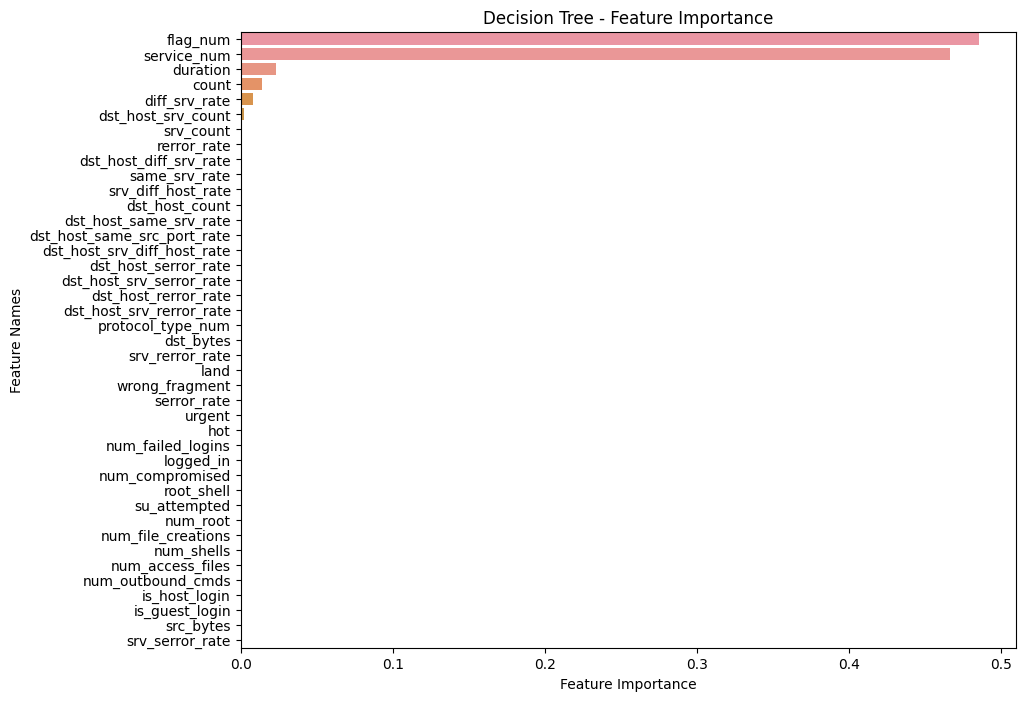

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
# Plot feature importances
def plot_feature_importances(importances, names, model_type='Random Forest'):
    feature_importance = np.array(importances)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' - Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

# Convert feature importances to a NumPy array
importances_array = feature_importances.toArray()

# Plot feature importances
plot_feature_importances(importances_array, numerical_cols, model_type='Decision Tree')

# Show the plot
plt.show()

In [ ]:
import shap
# Explain the model using SHAP
explainer = shap.TreeExplainer(model.stages[0])

In [ ]:
shap_values = explainer.shap_values(X, check_additivity=False)

In [ ]:
import numpy as np
# Summarize the feature importance
feature_importance = np.abs(shap_values).mean(axis=0)
print("Feature Importance:", feature_importance)

Feature Importance: [[0.0018001  0.         0.         ... 0.         0.04512017 0.0910679 ]
 [0.0018001  0.         0.         ... 0.         0.04088917 0.08822652]
 [0.0018001  0.         0.         ... 0.         0.04330753 0.0630747 ]
 ...
 [0.06512597 0.         0.         ... 0.         0.04256085 0.08931035]
 [0.05458716 0.         0.         ... 0.         0.03883783 0.08479831]
 [0.05458716 0.         0.         ... 0.         0.03883783 0.08479831]]


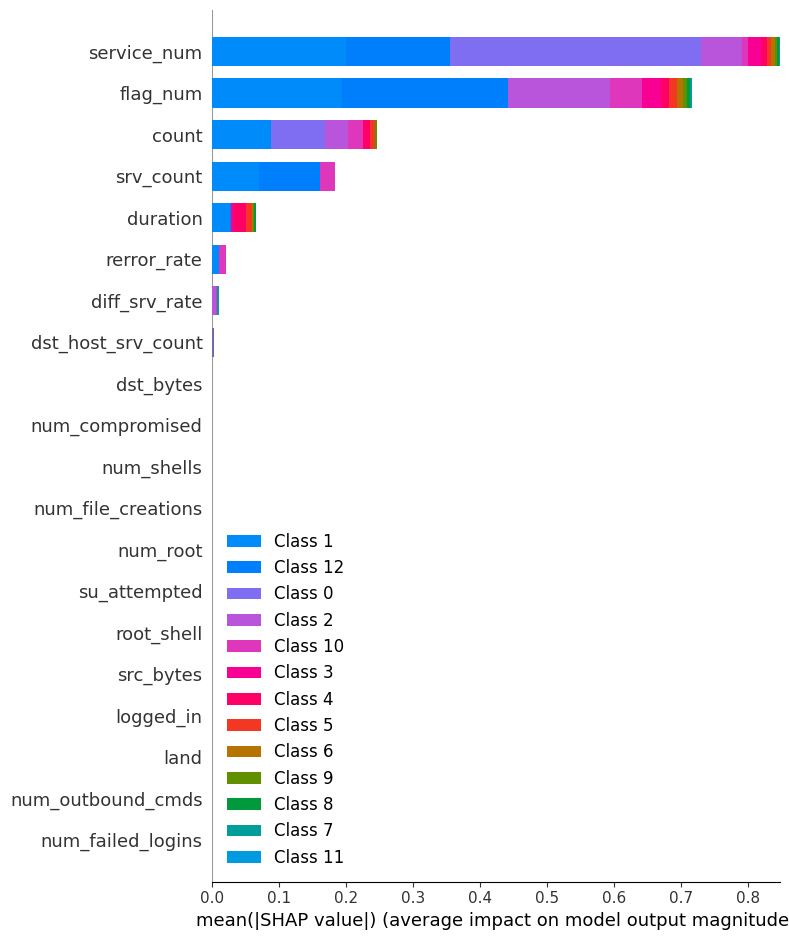

In [ ]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, X, feature_names=numerical_cols)

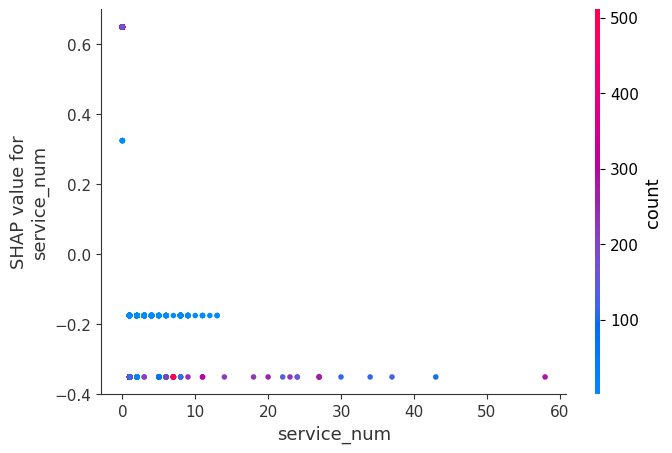

In [ ]:
# SHAP dependence plot for a specific feature
feature_of_interest = 'service_num'
shap.dependence_plot(feature_of_interest, shap_values[0], X, feature_names=numerical_cols)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Define hyperparameter grids for each model
paramGrid_lr1 = (ParamGridBuilder()
                .addGrid(lr1.maxIter, [10, 20])
                .addGrid(lr1.regParam, [0.1, 0.3])
                .addGrid(lr1.elasticNetParam, [0.2, 0.8])
                .build())

paramGrid_dt1 = (ParamGridBuilder()
                .addGrid(dt1.maxDepth, [5, 10])
                .addGrid(dt1.maxBins, [66, 70])
                .build())

paramGrid_rf1 = (ParamGridBuilder()
                .addGrid(rf1.numTrees, [10, 20])
                .addGrid(rf1.maxDepth, [5, 10])
                .addGrid(rf1.maxBins, [65, 70])
                .build())

paramGrid_nb1 = (ParamGridBuilder()
                .addGrid(nb1.smoothing, [0.5, 1.5])
                .build())

# Define hyperparameter grid for OneVsRest
paramGrid_lsvc1 = (ParamGridBuilder()
                 .addGrid(lsvc1.maxIter, [5, 10])
                 .build())

# OneVsRest wrapper
paramGrid_ovr1 = OneVsRest(classifier=paramGrid_lsvc1)

paramGrid_mlp1 = (ParamGridBuilder()
                 .addGrid(multilayer_perceptron1.layers, [[len(numerical_cols), 10, 5, 38], [len(numerical_cols), 15, 10, 38]])
                 .addGrid(multilayer_perceptron1.blockSize, [128, 256])
                 .build())

In [ ]:
# Dictionary of models and their respective hyperparameter grids
models_and_params = {"Logistic Regression": (lr1, paramGrid_lr1),
                    "Decision Tree": (dt1, paramGrid_dt1),
                     "Naive Bayes": (nb1, paramGrid_nb1),
                     "Random Forest": (rf1,paramGrid_rf1),
                    # "Linear SVM": (ovr1, param_grid1),  # Using OneVsRest for Linear SVM
                     "Multilayer Perceptron": (multilayer_perceptron1, paramGrid_mlp1)
                    }

In [ ]:
# Perform hyperparameter tuning using GridSearchCV
print("\nModels Evaluation with Hyperparameter Tuning:")
print("{:-<45}".format(""))
for model_name, (model, paramGrid) in models_and_params.items():
    print(model_name)

    # Create CrossValidator
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction"),
                              numFolds=3)  # You can adjust the number of folds

    # Fit the model
    best_model = crossval.fit(train_set1)

    # Make predictions
    predictions = best_model.transform(test_set1)
    predictions.cache()

    # Evaluate performance
    evaluator = MulticlassClassificationEvaluator(labelCol="label_num", predictionCol="prediction")

    for m in metrics:
        evaluator.setMetricName(m)
        metric = evaluator.evaluate(predictions)
        print("{name} = {value:.2f}".format(name=m, value=metric))

    print("{:-<45}".format(""))


Models Evaluation with Hyperparameter Tuning:
---------------------------------------------
Logistic Regression
accuracy = 0.95
weightedPrecision = 0.92
weightedRecall = 0.95
f1 = 0.93
---------------------------------------------
Decision Tree
accuracy = 0.99
weightedPrecision = 0.98
weightedRecall = 0.99
f1 = 0.98
---------------------------------------------
Naive Bayes
accuracy = 0.58
weightedPrecision = 0.62
weightedRecall = 0.58
f1 = 0.59
---------------------------------------------
Random Forest
accuracy = 0.99
weightedPrecision = 0.98
weightedRecall = 0.99
f1 = 0.98
---------------------------------------------
Multilayer Perceptron
accuracy = 0.94
weightedPrecision = 0.91
weightedRecall = 0.94
f1 = 0.92
---------------------------------------------
